In [ ]:
# Install required packages
!apt-get install -y libxml2-dev libxslt1-dev zlib1g-dev
!pip install rdkit-pypi
!pip install scikit-learn
!pip install enumerate-smiles
!pip install matplotlib seaborn

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from rdkit import Chem
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from enumerate_smiles import SmilesEnumerator

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libxml2-dev is already the newest version (2.9.13+dfsg-1ubuntu0.4).
zlib1g-dev is already the newest version (1:1.2.11.dfsg-2ubuntu9.2).
zlib1g-dev set to manually installed.
The following NEW packages will be installed:
  libxslt1-dev
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 219 kB of archives.
After this operation, 2,058 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libxslt1-dev amd64 1.1.34-4ubuntu0.22.04.1 [219 kB]
Fetched 219 kB in 0s (1,009 kB/s)
Selecting previously unselected package libxslt1-dev:amd64.
(Reading database ... 123595 files and directories currently installed.)
Preparing to unpack .../libxslt1-dev_1.1.34-4ubuntu0.22.04.1_amd64.deb ...
Unpacking libxslt1-dev:amd64 (1.1.34-4ubuntu0.22.04.1) ...
Setting up libxslt1-dev:amd64 (1.1.34-4ubuntu0.22.04.1) ...
Processing triggers for 

In [ ]:
# Upload file from PC
uploaded = files.upload()

Saving SMILES_Big_Data_Set.csv to SMILES_Big_Data_Set.csv


In [ ]:
# Load data from the uploaded file
file_name = next(iter(uploaded.keys()))
data = pd.read_csv(file_name)

In [ ]:
# Data Preprocessing
# Drop rows with missing values
data = data.dropna()


In [ ]:
# EDA Step 2: Check for missing values
print("\nMissing values in each column:")
print(data.isnull().sum())



Missing values in each column:
SMILES       0
pIC50        0
mol          0
num_atoms    0
logP         0
dtype: int64


In [ ]:
# Convert 'mol' column from string representation to RDKit Mol object if needed
data['mol'] = data['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))


In [ ]:
# EDA Step 1: Overview of the Dataset
print("Dataset Shape:", data.shape)
print("Dataset Columns:", data.columns)
print("First few rows of the dataset:")
print(data.head())

Dataset Shape: (15037, 5)
Dataset Columns: Index(['SMILES', 'pIC50', 'mol', 'num_atoms', 'logP'], dtype='object')
First few rows of the dataset:
                                              SMILES  pIC50  \
0         O=S(=O)(Nc1cccc(-c2cnc3ccccc3n2)c1)c1cccs1   4.26   
1  O=c1cc(-c2nc(-c3ccc(-c4cn(CCP(=O)(O)O)nn4)cc3)...   4.34   
2             NC(=O)c1ccc2c(c1)nc(C1CCC(O)CC1)n2CCCO   4.53   
3                NCCCn1c(C2CCNCC2)nc2cc(C(N)=O)ccc21   4.56   
4                  CNC(=S)Nc1cccc(-c2cnc3ccccc3n2)c1   4.59   

                                                mol  num_atoms    logP  
0  <rdkit.Chem.rdchem.Mol object at 0x7dc91df11fc0>         25  4.1591  
1  <rdkit.Chem.rdchem.Mol object at 0x7dc91df11e00>         36  3.6743  
2  <rdkit.Chem.rdchem.Mol object at 0x7dc91df11d20>         23  1.5361  
3  <rdkit.Chem.rdchem.Mol object at 0x7dc91df119a0>         22  0.9510  
4  <rdkit.Chem.rdchem.Mol object at 0x7dc91df117e0>         21  3.2130  


In [ ]:
# EDA Step 3: Statistical Summary
print("\nStatistical Summary:")
print(data.describe())


Statistical Summary:
              pIC50     num_atoms          logP
count  15037.000000  15037.000000  15037.000000
mean       0.998739     18.930239      2.465004
std        2.479588      8.444724      1.441221
min        0.000000      3.000000     -0.404900
25%        0.000000     13.000000      1.414900
50%        0.010000     17.000000      2.282800
75%        0.130000     23.000000      3.308400
max       10.970000     85.000000     15.879200


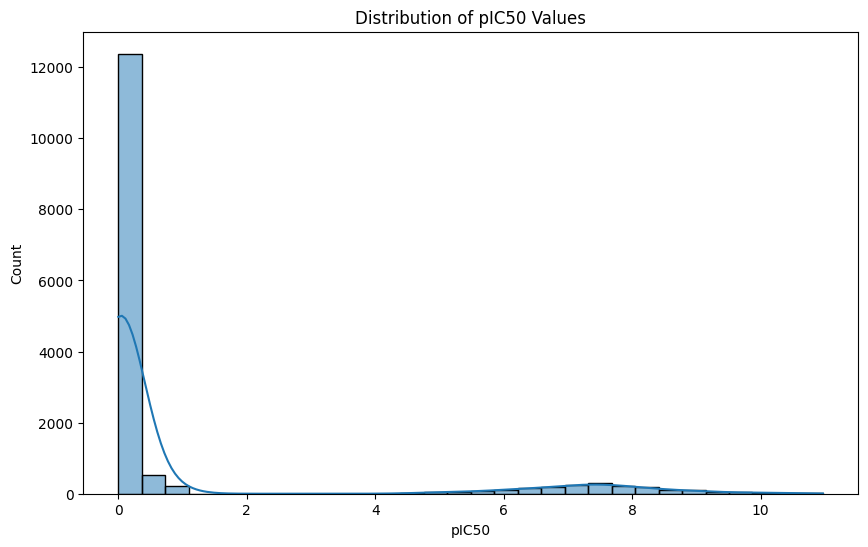

In [ ]:
# EDA Step 4: Distribution of pIC50 values
plt.figure(figsize=(10, 6))
sns.histplot(data['pIC50'], bins=30, kde=True)
plt.xlabel('pIC50')
plt.title('Distribution of pIC50 Values')
plt.show()

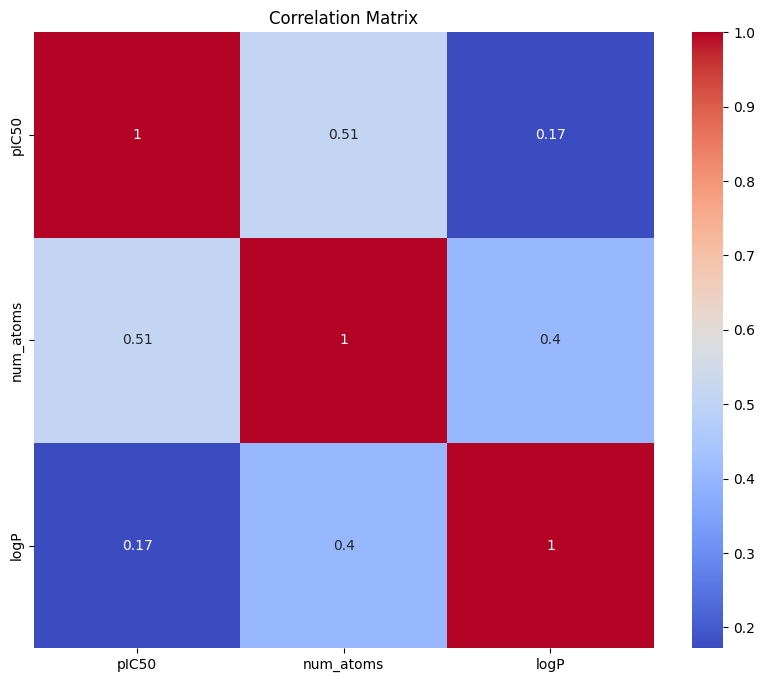

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# EDA Step 5: Correlation Matrix
plt.figure(figsize=(10, 8))

# Select only numeric columns
numeric_data = data.select_dtypes(include=[float, int])

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

<Figure size 1400x800 with 0 Axes>

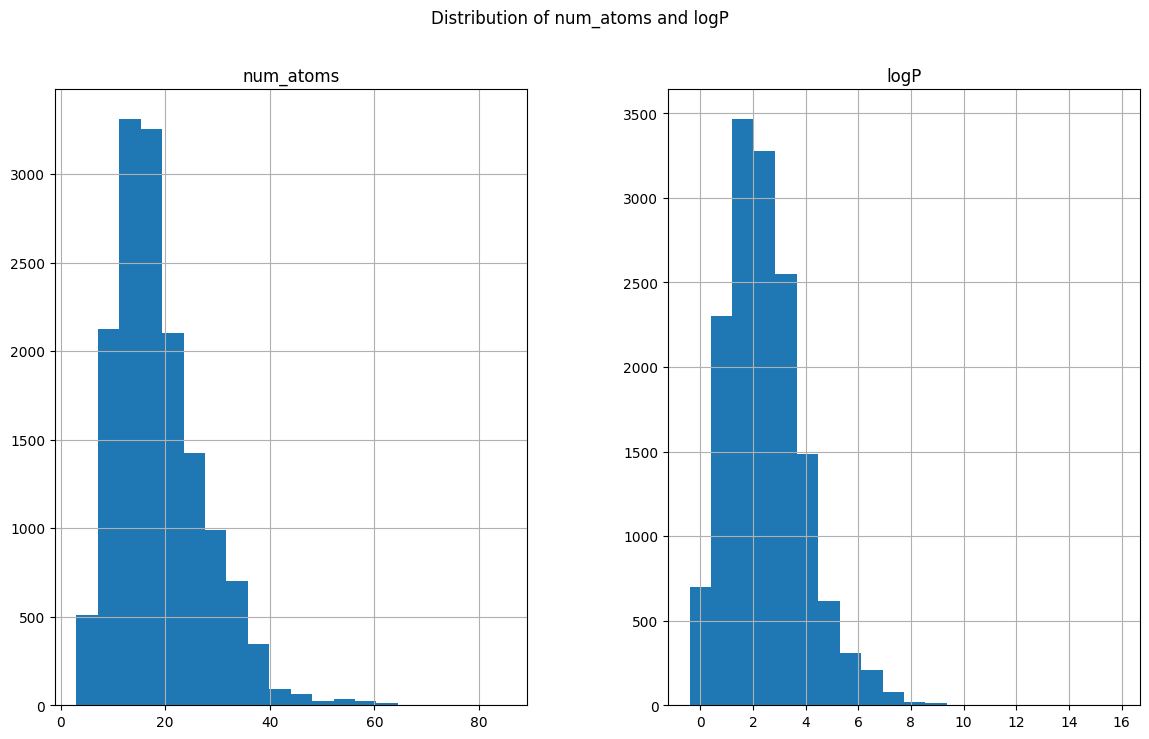

In [ ]:
# EDA Step 6: Check distribution of numerical features
plt.figure(figsize=(14, 8))
data[['num_atoms', 'logP']].hist(bins=20, figsize=(14, 8))
plt.suptitle('Distribution of num_atoms and logP')
plt.show()

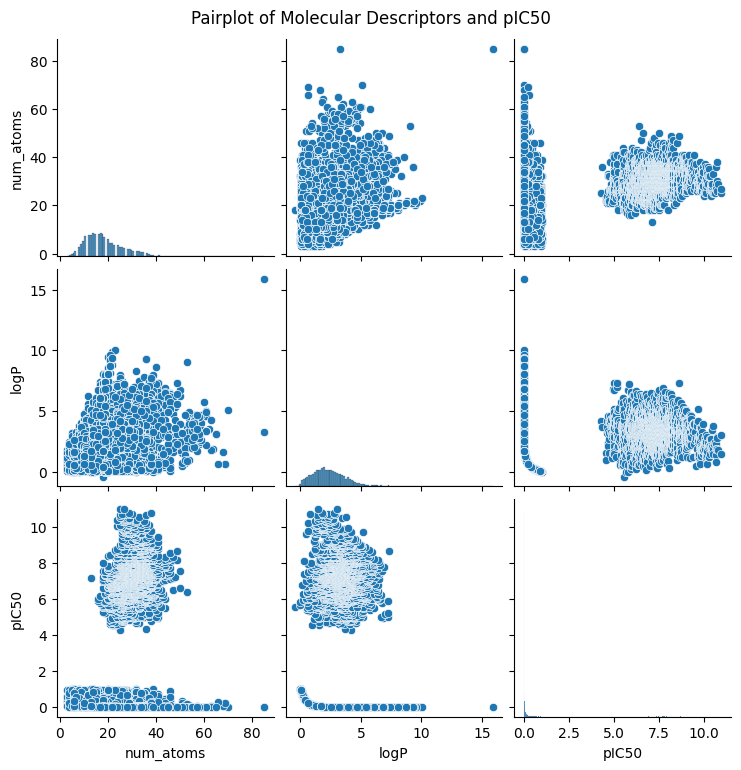

In [ ]:
# EDA Step 7: Pairplot of molecular descriptors vs pIC50
sns.pairplot(data[['num_atoms', 'logP', 'pIC50']])
plt.suptitle('Pairplot of Molecular Descriptors and pIC50', y=1.02)
plt.show()

In [ ]:
# Initialize the SMILES Enumerator
sme = SmilesEnumerator()

# Function to convert SMILES to fingerprint
def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    arr = np.zeros((2048,), dtype=int)
    AllChem.DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

def randomize_smiles(smiles, random_type="shuffle"):
    """Randomize a SMILES string."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return []
    if random_type == "shuffle":
        return [Chem.MolToSmiles(mol, doRandom=True)]
    else:
        return [Chem.MolToSmiles(mol)]

def smiles_to_fingerprint(smiles):
    """Convert a SMILES string to a Morgan fingerprint."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    arr = np.zeros((2048,), dtype=int)
    AllChem.DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# Apply SMILES enumeration and conversion
fingerprints = []
indices = []
for i, smiles in enumerate(data['SMILES']):
    enumerated_smiles = randomize_smiles(smiles)
    for sm in enumerated_smiles:
        fp = smiles_to_fingerprint(sm)
        if fp is not None:
            fingerprints.append(fp)
            indices.append(i)  # Track original indices

# Convert list of fingerprints to NumPy array
X = np.array(fingerprints)

# Ensure 'y' and additional features match 'X'
indices = np.array(indices)
y = data.iloc[indices]['pIC50'].values
additional_features = data.iloc[indices][['num_atoms', 'logP']].values

# Include other features if desired
X = np.hstack((X, additional_features))


In [ ]:
print("Shape of X:", X.shape)
print("Shape of additional_features:", additional_features.shape)


Shape of X: (15037, 2050)
Shape of additional_features: (15037, 2)


In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import pandas as pd

def randomize_smiles(smiles, num_variants=1):
    """Generate multiple SMILES representations."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return []
    return [Chem.MolToSmiles(mol, doRandom=True) for _ in range(num_variants)]

def smiles_to_fingerprint(smiles):
    """Convert a SMILES string to a Morgan fingerprint."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    arr = np.zeros((2048,), dtype=int)
    AllChem.DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# Apply SMILES enumeration and conversion
fingerprints = []
indices = []
for i, smiles in enumerate(data['SMILES']):
    enumerated_smiles = randomize_smiles(smiles, num_variants=5)  # Generate 5 SMILES representations
    for sm in enumerated_smiles:
        fp = smiles_to_fingerprint(sm)
        if fp is not None:
            fingerprints.append(fp)
            indices.append(i)  # Track original indices

# Convert list of fingerprints to NumPy array
X = np.array(fingerprints)
indices = np.array(indices)

# Ensure 'y' and additional features match 'X'
y = data.iloc[indices]['pIC50'].values
additional_features = data.iloc[indices][['num_atoms', 'logP']].values

print("Shape of X:", X.shape)
print("Shape of additional_features:", additional_features.shape)

# Check if shapes match before concatenation
if X.shape[0] == additional_features.shape[0]:
    X = np.hstack((X, additional_features))
else:
    print("Error: Shapes of X and additional_features do not match.")


Shape of X: (75185, 2048)
Shape of additional_features: (75185, 2)


In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Train Model
model = RandomForestRegressor()
model.fit(X_train, y_train)


RandomForestRegressor()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Get predicted probabilities for the positive class
predictions = model.predict_proba(X_test)[:, 1]

# Calculate the median of the predicted probabilities
threshold = np.median(predictions)

# Convert predictions to binary classes based on the median threshold
predictions_binary = (predictions > threshold).astype(int)
y_test_binary = (y_test > threshold).astype(int)  # Ensure y_test is in the same binary format

# Calculate Precision, Recall, F1 Score, and Accuracy
precision = precision_score(y_test_binary, predictions_binary, zero_division=1)
recall = recall_score(y_test_binary, predictions_binary, zero_division=1)
f1 = f1_score(y_test_binary, predictions_binary, zero_division=1)
accuracy = accuracy_score(y_test_binary, predictions_binary)

# Print the median threshold and metrics
print(f"Threshold: {threshold}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

Threshold: nan
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Accuracy: 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:882: RuntimeWarning: invalid value encountered in divide
  proba /= len(self.estimators_)


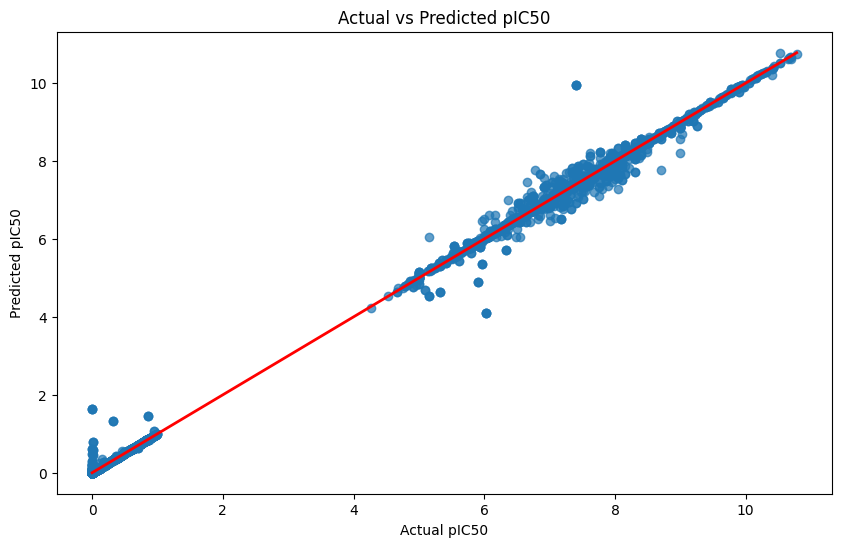

In [ ]:
# Visualization Step 1: Actual vs Predicted pIC50
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.7)
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.title('Actual vs Predicted pIC50')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.show()

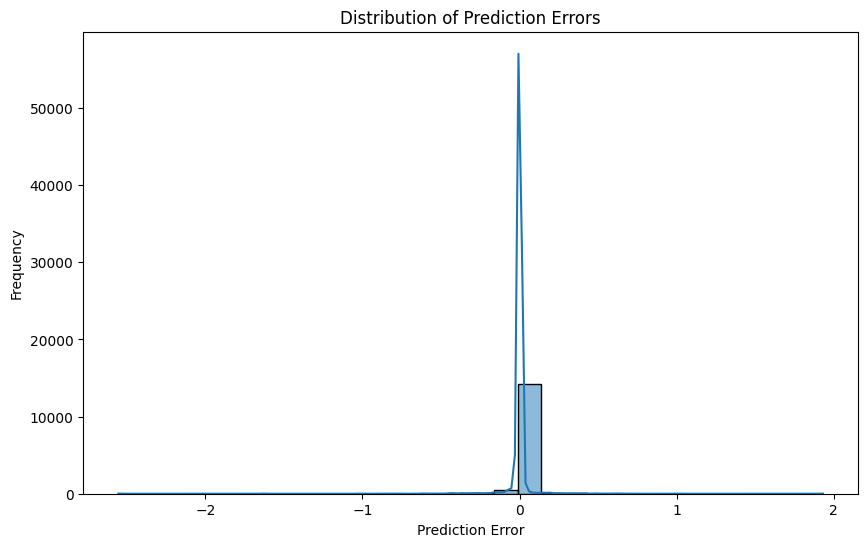

In [ ]:
# Visualization Step 2: Distribution of Errors
errors = y_test - predictions
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=30, kde=True)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.show()

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Train XGBoost Model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

xgb_predictions = xgb_model.predict(X_test)

# Calculate RMSE, MAE, and R²
rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
mae = mean_absolute_error(y_test, xgb_predictions)
r2 = r2_score(y_test, xgb_predictions)

# Display the metrics
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

RMSE: 0.34
MAE: 0.14
R²: 0.98


In [ ]:
# Get the predictions from the XGBoost model
xgb_predictions = xgb_model.predict(X_test)

# Calculate the median of the predicted probabilities
threshold = np.median(predictions)

# Convert regression predictions to binary class predictions
xgb_predictions_binary = (xgb_predictions > threshold).astype(int)
y_test_binary = (y_test > threshold).astype(int)  # Convert true values to binary class as well

# Calculate RMSE, MAE, and R² for regression
rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
mae = mean_absolute_error(y_test, xgb_predictions)
r2 = r2_score(y_test, xgb_predictions)

# Calculate Precision, Recall, F1 Score, and Accuracy for classification
precision = precision_score(y_test_binary, xgb_predictions_binary, zero_division=1)
recall = recall_score(y_test_binary, xgb_predictions_binary, zero_division=1)
f1 = f1_score(y_test_binary, xgb_predictions_binary, zero_division=1)
accuracy = accuracy_score(y_test_binary, xgb_predictions_binary)

# Display the metrics
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")

RMSE: 0.34
MAE: 0.14
R²: 0.98
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Accuracy: 1.00


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score

# Initialize the model
gbr_model = GradientBoostingRegressor()

# Train the model
gbr_model.fit(X_train, y_train)

# Make predictions
gbr_predictions = gbr_model.predict(X_test)

In [ ]:
# Calculate RMSE, MAE, and R²
rmse = np.sqrt(mean_squared_error(y_test, gbr_predictions))
mae = mean_absolute_error(y_test, gbr_predictions)
r2 = r2_score(y_test, gbr_predictions)

# Display the results
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

RMSE: 0.5924123084545703
MAE: 0.27549478999831173
R²: 0.9425527872414639


In [ ]:
# Determine the ideal threshold as the median of y_test
threshold = np.median(y_test)

# Convert the regression output to binary classification
y_test_binary = (y_test > threshold).astype(int)
gbr_predictions_binary = (gbr_predictions > threshold).astype(int)

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test_binary, gbr_predictions_binary)
precision = precision_score(y_test_binary, gbr_predictions_binary)
recall = recall_score(y_test_binary, gbr_predictions_binary)
f1 = f1_score(y_test_binary, gbr_predictions_binary)

# Display the classification results
print(f"Ideal Threshold: {threshold}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Ideal Threshold: 0.01
Accuracy: 0.64
Precision: 0.61
Recall: 0.66
F1 Score: 0.64
